In [1]:
#Train, val, Test splitter
import train_pytorch
import prepare_dataset
import random
import time 
from collections import Counter
import os
import numpy as np
import shutil
#os.chdir("/Users/kjartan/Documents/CompCogSci3/") 
os.chdir(r"C:\Users\kjart\OneDrive\Dokumenter\KU\3. semester\Cog sci 3\CompCogSci3")

In [3]:
language = "EN"
unsorted_data_dir = "raw_data/derivatives/"
annotation_file = f"raw_data/annotation/{language}/lpp{language}_word_information.csv"
random.seed(1234)

pos = "VERB"
oov = "-1"
binary = False


In [ ]:
#prepare_dataset.clear_data_dir()
#shutil.rmtree("aux_data/")
##the split is (0.8,0.1,0.1)
#prepare_dataset.fill_data_dir(unsorted_data_dir, prepare_dataset.config1, language)

In [4]:
#Move data back from aux_data/
for phase in os.listdir("aux_data/"):
    for run in os.listdir(f"aux_data/{phase}"):
        path = f"aux_data/{phase}/{run}/{language}/"
        for file in os.listdir(path):
            file_path = f"data/{phase}/{run}/{language}/{file}"
            shutil.move(f"aux_data/{phase}/{run}/{language}/{file}",file_path)
            #time.sleep(0.00001)

FileNotFoundError: [WinError 3] The system cannot find the path specified: 'aux_data/'

In [5]:


prepare_dataset.prepare_labels(annotation_file, "data/", language, pos=pos, oov=oov)

#binary = prepare_dataset.convert_to_binary_labels("data/", oov, language)

649  = number of classes


In [6]:
all_labels = []
for i in os.listdir("data"):
    if os.path.isdir("data/"+i):
        for phase in os.listdir("data/"+i):
            for run in range(9):
                path = f"data/{i}/{run}/{language}/labels.txt"
                with open(path, "r") as f:
                    lines = f.readlines()
                    for l in lines:
                        all_labels.append(l.strip("\n"))

from collections import Counter
import codecs

most_common = Counter(all_labels).most_common()
label_dict = {}
with codecs.open("label_dict.txt", "r", encoding="utf-8") as f:
    for i in f.readlines():
        k = i.split("=")
        label_dict[k[1].strip("\n ")] = k[0]
most_common_lemmas = []
for i in range(len(most_common)):
    lbl = most_common[i][0]
    most_common_lemmas.append((label_dict[lbl], most_common[i][1]))



In [7]:
vocab15 = []
off_set = 1
label_stats = most_common_lemmas[off_set+1:15+off_set+1]
for w, _ in label_stats: #top 15 words
    vocab15.append(w.strip())
    
print(vocab15)
print(label_stats)

['know', 'will', 'asked', 'come', 'make', 'see', 'understand', 'look', 'replied', 'made', 'would', 'say', 'looked', 'came', 'go']
[('know ', 1026), ('will ', 918), ('asked ', 756), ('come ', 702), ('make ', 648), ('see ', 648), ('understand ', 621), ('look ', 621), ('replied ', 513), ('made ', 513), ('would ', 486), ('say ', 459), ('looked ', 432), ('came ', 432), ('go ', 432)]


In [8]:
vocab = vocab15
prepare_dataset.prepare_handpicked_labels(annotation_file, "data/", vocab, oov=oov)

16  = number of classes


In [9]:
#Exclude data that corresponds to oov
with codecs.open("label_dict.txt", "r", encoding="utf-8") as f:
    for i in f.readlines():
        k = i.split("=")
        if k[0].strip() == oov:
            label_2_remove = int(k[1].strip("\n "))
            break
print(label_2_remove)
labels_dict = {}
for i in os.listdir("data"):
    if os.path.isdir("data/"+i):
        for phase in os.listdir("data/"+i):
            for run in range(9):
                labels = np.loadtxt(f"data/{i}/{run}/{language}/labels.txt")
                labels_dict[run] = labels

exclusion_idxs = {k:[] for k in range(9)}

for run in labels_dict.keys():
    for idx, label in enumerate(labels_dict[run]):
        if label==label_2_remove:
            exclusion_idxs[run].append(idx)


for i in os.listdir("data"):
    if os.path.isdir("data/"+i):
        for phase in os.listdir("data/"+i):
            for run in range(9):
                path = f"data/{i}/{run}/{language}/labels.txt"
                with open(path, "r") as f:
                    lines = f.readlines()
                with open(path, "w") as f:
                    for line in lines:
                        if line.strip("\n ") != str(label_2_remove):
                            f.write(line)

count = 0
for phase in os.listdir("data/"):
    for run in range(9):
        path = f"data/{phase}/{run}/{language}/"
        for file in os.listdir(path):
            if file.endswith(".txt"):
                continue
            file_path = f"data/{phase}/{run}/{language}/{file}"
            idx = file.split("_")[-1][:-4]
            if int(idx) in exclusion_idxs[run]:
                count +=1 
                dest = f"aux_data/{phase}/{run}/{language}/"
                if not os.path.exists(dest):
                    os.makedirs(dest)
                shutil.move(file_path, f"aux_data/{phase}/{run}/{language}/")
                #time.sleep(0.00001)
print("moved ", count, " files")


15
moved  100261  files


In [10]:

def count_files():
    counts = {}
    # Iterate directory
    for phase in os.listdir("data"):
        if os.path.isdir("data/"+phase):
            count=0
            for run in os.listdir(f"data/{phase}/"):
                for file in os.listdir(f"data/{phase}/{run}/{language}"):
                    if file.endswith(".npy"):
                        count += 1
        counts[phase] = count
    return counts

count_files()

{'Test': 436, 'Train': 19107, 'Val': 2340}

In [11]:
def calc_baseline(lbl = "data/Test/", language = "EN"):
    prob = 0
    labels = []
    for run in os.listdir(lbl):
        path = lbl +"/"+ run + "/" + language
        multiplier = len(os.listdir(path))-1
        if multiplier>0:
            for _ in range(int(multiplier/len(np.loadtxt(path+"/labels.txt")))):
                labels.append(np.loadtxt(path+"/labels.txt"))
    labels = np.concatenate(labels).ravel()
    total = labels.size
    label_c = Counter(labels)
    for _, v in label_c.items():
        prob += (v/total)**2
    return prob

calc_baseline()

0.09827920571846933

In [12]:
import json
import datetime
with codecs.open("config_stats.txt", "a", encoding="utf-8") as f:
    f.write("\n")
    f.write(f"{datetime.datetime.now()}\n")
    f.write(f"{off_set+1}th to {off_set+15}th\n")
    for i in label_stats:
        f.write(str(i) + ", ")
    f.write("\n")
    f.write(json.dumps(count_files()))
    f.write("\n")
f.close()

In [13]:
batch_size=50
config = f"config2_{language}_top15{pos}"

2022-12-08 21:29:14.973284


c:\Users\kjart\OneDrive\Dokumenter\KU\3. semester\Cog sci 3\CompCogSci3\mt_deep-master\scripts\model_m2dcnn.py:78: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(m.weight, gain=nn.init.calculate_gain('relu'))


cuda
Epoch 1/10
-------------
{'train': <torch.utils.data.dataloader.DataLoader object at 0x000002286C4BB0D0>, 'valid': <torch.utils.data.dataloader.DataLoader object at 0x000002286C4B90F0>, 'test': <torch.utils.data.dataloader.DataLoader object at 0x000002286C302BC0>}
 52.34 %
 104.67 %
 157.01 %
##### train Loss: 2.7075 Acc: 0.1191 #####
{'train': <torch.utils.data.dataloader.DataLoader object at 0x000002286C4BB0D0>, 'valid': <torch.utils.data.dataloader.DataLoader object at 0x000002286C4B90F0>, 'test': <torch.utils.data.dataloader.DataLoader object at 0x000002286C302BC0>}
##### valid Loss: 2.6787 Acc: 0.0970 #####
Epoch 2/10
-------------
{'train': <torch.utils.data.dataloader.DataLoader object at 0x000002286C4BB0D0>, 'valid': <torch.utils.data.dataloader.DataLoader object at 0x000002286C4B90F0>, 'test': <torch.utils.data.dataloader.DataLoader object at 0x000002286C302BC0>}
 52.34 %
 104.67 %
 157.01 %
##### train Loss: 2.6243 Acc: 0.1606 #####
{'train': <torch.utils.data.dataloader

  0%|          | 0/9 [00:00<?, ?it/s]

Test Accuracy: 0.1055


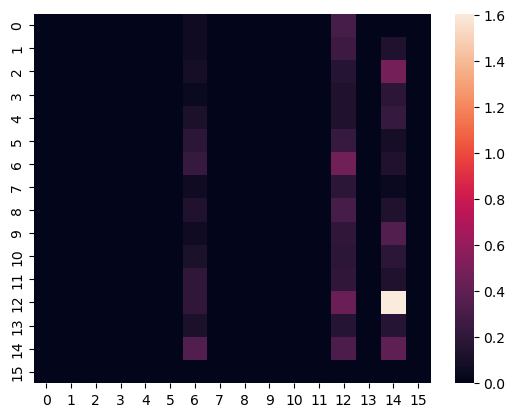

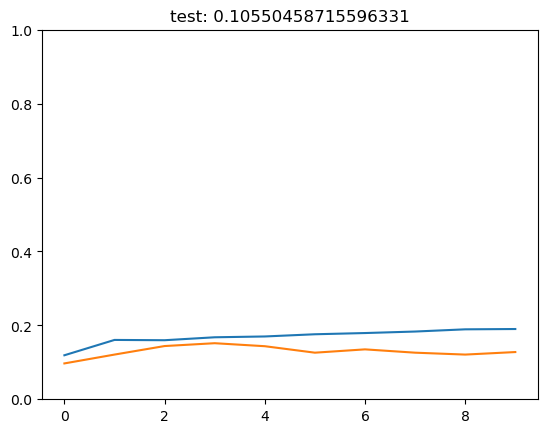

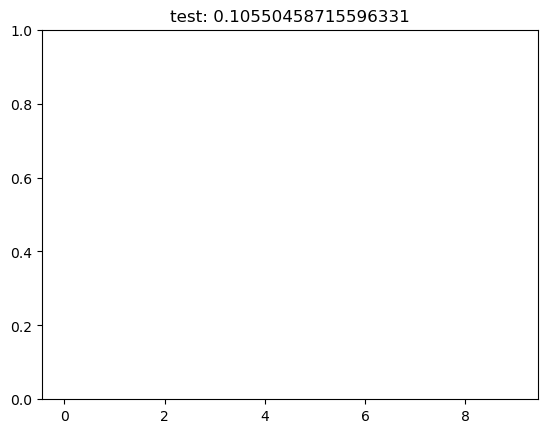

0:41:40.601037


In [14]:

train_pytorch.train(binary=False, batch_size = batch_size, num_epochs = 10, config=config, model = "2d", weights=None)

16


  0%|          | 0/9 [00:00<?, ?it/s]

..
..
..
..
..
..
..
..
..
Test Accuracy: 0.1055


(M2DCNN(
   (up_conv): Conv2d(
     (conv_block): Sequential(
       (0): Conv2d(73, 16, kernel_size=(3, 3), stride=(1, 1))
       (1): mish()
       (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
       (3): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
       (5): mish()
       (6): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
       (7): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     )
   )
   (front_conv): Conv2d(
     (conv_block): Sequential(
       (0): Conv2d(90, 16, kernel_size=(3, 3), stride=(1, 1))
       (1): mish()
       (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
       (3): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1)

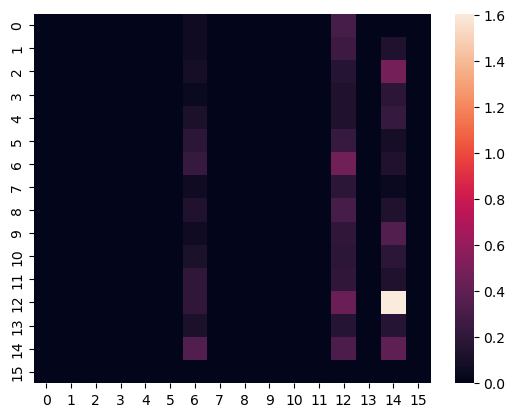

In [15]:
import model_m2dcnn as model
from torch.utils.data import DataLoader
from dataset import lpp_Dataset

batch_size = 50
binary = False
test_dataloader = DataLoader(lpp_Dataset("data/Test/"), batch_size=batch_size, shuffle=False)
if binary:
        nb_classes = 2
else:
    with open("label_dict.txt", "r") as f:
        nb_classes = len(f.readlines())
      
print(nb_classes)
train_pytorch.test(model.M2DCNN(numClass=nb_classes, numFeatues=30880, DIMX=74, DIMY=90, DIMZ=73), config,f"results/{config}_weights.pth", nb_classes, test_dataloader)